# 对称

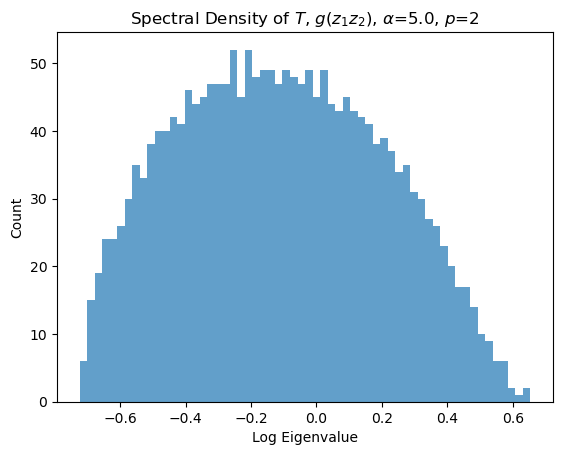

Subspace alignment score: 0.3598
Cosine similarity matrix:
 [[0.45  0.416]
 [0.416 0.414]]

[Individual Eigenvector Alignment Scores]
      Type       λ  Alignment Score
0  eig1992  3.7300           0.0955
1  eig1993  3.7693           0.0409
2  eig1994  3.7752           0.0655
3  eig1995  3.8706           0.0286
4  eig1996  3.9356           0.0651
5  eig1997  4.1131           0.2230
6  eig1998  4.4669           0.2047
7  eig1999  4.5050           0.3182

[Eigenvector Pair Subspace Alignment Scores]
               Type                  λ Pair  Alignment Score
0   eig1992+eig1993   (3.730026, 3.7692595)           0.1850
1   eig1992+eig1994   (3.730026, 3.7751896)           0.2128
2   eig1992+eig1995    (3.730026, 3.870582)           0.1821
3   eig1992+eig1996    (3.730026, 3.935615)           0.2167
4   eig1992+eig1997   (3.730026, 4.1131077)           0.4747
5   eig1992+eig1998   (3.730026, 4.4668584)           0.4399
6   eig1992+eig1999   (3.730026, 4.5050254)           0.6367
7   eig1

In [98]:
import torch
import numpy as np
import pandas as pd
from scipy.special import kv  # Bessel function Kν
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from itertools import combinations

# ========== Parameters ==========
n, d, p = 5000, 1000, 2
alpha = n / d
device = torch.device("cpu")

# ========== Step 1: Generate Data ==========
torch.manual_seed(0)
W_star = torch.nn.functional.normalize(torch.randn(d, p), dim=0)
X = torch.randn(n, d)
Z = X @ W_star
y = (Z[:, 0] * Z[:, 1]).numpy()  # scalar response

# ========== Step 2: Construct T(y) using Bessel approximation ==========
def construct_T_y(y_i):
    abs_y = np.abs(y_i) + 1e-8
    K0 = kv(0, abs_y)
    K1 = kv(1, abs_y)
    r = abs_y * (K1 / K0)
    return torch.tensor([[r, y_i], [y_i, r]], dtype=torch.float32)

I2 = torch.eye(2)
L_sym = torch.zeros((2*d, 2*d))  # 对称谱矩阵（原 T_hat）

for i in range(n):
    x_i = X[i].reshape(d, 1)
    kron_x = torch.kron(I2, x_i)  # (2d, 2)
    T_yi = construct_T_y(y[i])    # (2, 2)
    L_sym += kron_x @ T_yi @ kron_x.T

L_sym /= n

# ========== Step 3: Spectral Decomposition ==========
eigvals_sym, eigvecs_sym = torch.linalg.eigh(L_sym)
top_vals, indices = torch.topk(eigvals_sym, p)
U_top = eigvecs_sym[:, indices]  # (2d, p)

# ========== Step 4: Compute Subspace Alignment ==========
U_top_np = U_top.numpy()
U_top_reshaped = U_top_np.reshape(d, 2, p, order='F').sum(axis=1)  # (d, p)

W_np = W_star.numpy()
sim_matrix = cosine_similarity(U_top_reshaped.T, W_np.T)
subspace_score = np.linalg.norm(sim_matrix, 'fro')**2 / p

# ========== Step 5: Plot Spectrum ==========
plt.hist(np.log10(eigvals_sym.numpy()), bins=60, alpha=0.7)
plt.title(f"Spectral Density of $T$, $g(z_1z_2)$, $\\alpha$={alpha:.1f}, $p$={p}")
plt.xlabel("Log Eigenvalue")
plt.ylabel("Count")
plt.show()

print("Subspace alignment score:", round(subspace_score, 4))
print("Cosine similarity matrix:\n", np.round(sim_matrix, 3))

# ========== Step 6: Unified Evaluation ==========

def elevate_W_star_to_symmetric(W_star):
    return np.vstack([
        np.hstack([W_star, np.zeros_like(W_star)]),
        np.hstack([np.zeros_like(W_star), W_star])
    ])

def elevate_vector(v, position='top', d=None):
    if d is None:
        d = v.shape[0]
    if position == 'top':
        return np.concatenate([v, np.zeros(d)])
    else:
        return np.concatenate([np.zeros(d), v])

def evaluate_alignment_unified(eig_vals, eig_vecs, W_star, top_k=8, mode='symmetric'):
    d, p = W_star.shape
    W_sym_np = elevate_W_star_to_symmetric(W_star.numpy())
    W_sym = torch.tensor(W_sym_np, dtype=torch.float32)
    W_normed = W_sym / torch.norm(W_sym, dim=0, keepdim=True)

    indices = np.argsort(eig_vals)[-top_k:]

    individual_scores = []
    for i in indices:
        vec = eig_vecs[:, i]
        if mode == 'asymmetric':
            vec = elevate_vector(vec, position='top', d=d)
        vec_torch = torch.tensor(vec, dtype=torch.float32)
        vec_norm = vec_torch / torch.norm(vec_torch)
        cos_sim = torch.abs(torch.matmul(W_normed.T, vec_norm)).max().item()
        individual_scores.append((f"eig{i}", eig_vals[i], cos_sim))

    pair_scores = []
    for i, j in combinations(indices, 2):
        vi = eig_vecs[:, i]
        vj = eig_vecs[:, j]
        if mode == 'asymmetric':
            vi = elevate_vector(vi, 'top', d=d)
            vj = elevate_vector(vj, 'top', d=d)
        V = np.stack([vi, vj], axis=1)
        Q, _ = np.linalg.qr(V)
        Q_torch = torch.tensor(Q, dtype=torch.float32)
        proj = Q_torch @ Q_torch.T @ W_sym
        align_score = torch.norm(proj).item()
        pair_scores.append((f"eig{i}+eig{j}", (eig_vals[i], eig_vals[j]), align_score))

    individual_df = pd.DataFrame(individual_scores, columns=["Type", "λ", "Alignment Score"])
    pair_df = pd.DataFrame(pair_scores, columns=["Type", "λ Pair", "Alignment Score"])
    return individual_df, pair_df

# ========== Step 7: Run Unified Evaluation ==========
eigvals_np = eigvals_sym.numpy()
eigvecs_np = eigvecs_sym.numpy()

individual_df, pair_df = evaluate_alignment_unified(
    eigvals_np, eigvecs_np, W_star, top_k=8, mode='symmetric'
)

# ========== Optional: Display Results ==========
print("\n[Individual Eigenvector Alignment Scores]")
print(individual_df.round(4))

print("\n[Eigenvector Pair Subspace Alignment Scores]")
print(pair_df.round(4))


### 优化，对于上述代码没有将范围限制在【0，1】

Subspace alignment score: 0.4999


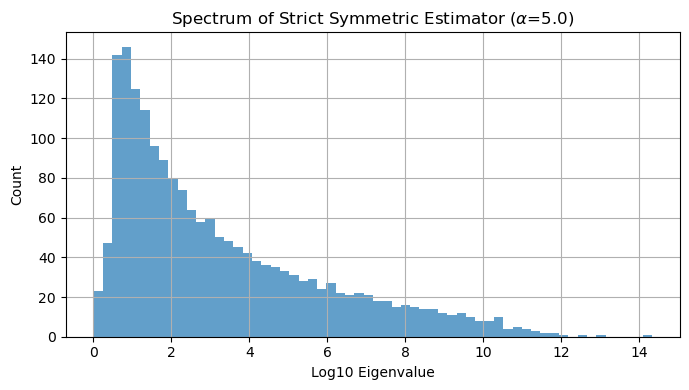


[Individual Eigenvector Alignment Scores]
      Type        λ  Alignment Score
0  eig1992  11.4846           0.0012
1  eig1993  11.6467           0.0154
2  eig1994  11.7092           0.0222
3  eig1995  11.7515           0.0703
4  eig1996  12.0398           0.0208
5  eig1997  12.4755           0.1567
6  eig1998  12.9617           0.2435
7  eig1999  14.3322           0.2571

[Eigenvector Pair Subspace Alignment Scores]
               Type                  λ Pair  Alignment Score
0   eig1992+eig1993  (11.484554, 11.646711)           0.0260
1   eig1992+eig1994  (11.484554, 11.709238)           0.0387
2   eig1992+eig1995  (11.484554, 11.751511)           0.0427
3   eig1992+eig1996  (11.484554, 12.039775)           0.0224
4   eig1992+eig1997    (11.484554, 12.4755)           0.0301
5   eig1992+eig1998   (11.484554, 12.96169)           0.3407
6   eig1992+eig1999  (11.484554, 14.332246)           0.3677
7   eig1993+eig1994  (11.646711, 11.709238)           0.0348
8   eig1993+eig1995  (11.6467

In [2]:
import torch
import numpy as np
import pandas as pd
from scipy.special import kv  # Bessel function Kν
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from itertools import combinations

# ========== Parameters ==========
n, d, p = 5000, 1000, 2
alpha = n / d
np.random.seed(42)
device = torch.device("cpu")

# ========== Step 1: Generate Data ==========
torch.manual_seed(42)
W_star = torch.nn.functional.normalize(torch.randn(d, p), dim=0)
X = torch.randn(n, d)
Z = X @ W_star
y = (Z[:, 0] * Z[:, 1]).numpy()  # scalar response

# ========== Step 2: Construct T(y) using adjustable Bessel approximation ==========
def construct_T_y_adjustable(y_i, gamma=1, clip=1e-2, scale=5):
    y_scaled = scale * y_i
    abs_y = np.abs(y_scaled) + 1e-8
    K0 = kv(0, abs_y)
    K1 = kv(1, abs_y)
    r = abs_y * (K1 / (K0 + 1e-6))
    r = np.clip(r, clip, None)
    return torch.tensor([
        [r, gamma * y_scaled],
        [gamma * y_scaled, r]
    ], dtype=torch.float32)

# ========== Step 3: Construct Spectral Matrix ==========
I2 = torch.eye(2)
L_sym = torch.zeros((2*d, 2*d))

for i in range(n):
    x_i = X[i].reshape(d, 1)
    kron_x = torch.kron(I2, x_i)  # (2d, 2)
    T_yi = construct_T_y_adjustable(y[i], gamma=1, clip=1e-2, scale=5.0)
    L_sym += kron_x @ T_yi @ kron_x.T

L_sym /= n

# ========== Step 4: Spectral Decomposition ==========
eigvals_sym, eigvecs_sym = torch.linalg.eigh(L_sym)
top_vals, indices = torch.topk(eigvals_sym, p)
U_top = eigvecs_sym[:, indices]  # (2d, p)

# ========== Step 5: Subspace Alignment Score ==========
def elevate_W_star_to_symmetric(W_star):
    return np.vstack([
        np.hstack([W_star, np.zeros_like(W_star)]),
        np.hstack([np.zeros_like(W_star), W_star])
    ])

U_top_np = U_top.numpy()
W_sym_np = elevate_W_star_to_symmetric(W_star.numpy())
Q1, _ = np.linalg.qr(U_top_np)
Q2, _ = np.linalg.qr(W_sym_np)
overlap = Q1.T @ Q2
subspace_score = np.linalg.norm(overlap, 'fro')**2 / p

print("Subspace alignment score:", round(subspace_score, 4))

# ========== Step 6: Plot Spectrum ==========
eigvals_np = eigvals_sym.numpy()
eigvals_pos = eigvals_np[eigvals_np > 1e-12]  # 排除非正值（含 0）

plt.figure(figsize=(7, 4))
plt.hist(eigvals_pos, bins=60, alpha=0.7)
plt.title(f"Spectrum of Strict Symmetric Estimator ($\\alpha$={alpha:.1f})")
plt.xlabel("Log10 Eigenvalue")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()


# ========== Step 7: Unified Evaluation ==========

def elevate_vector(v, position='top', d=None):
    if d is None:
        d = v.shape[0]
    if position == 'top':
        return np.concatenate([v, np.zeros(d)])
    else:
        return np.concatenate([np.zeros(d), v])

def evaluate_alignment_unified(eig_vals, eig_vecs, W_star, top_k=8, mode='symmetric'):
    d, p = W_star.shape
    W_sym_np = elevate_W_star_to_symmetric(W_star.numpy())
    Q_true, _ = np.linalg.qr(W_sym_np[:, :p])  # ✅ 正确使用 p=2 维的信号空间


    indices = np.argsort(eig_vals)[-top_k:]
    individual_scores = []

    for i in indices:
        vec = eig_vecs[:, i]  # 取一个谱向量 (2d,)
        
        # === reshape 为 d × 2 的矩阵 ===
        try:
            V = vec.reshape(2, d).T  # 变为 d × 2
        except:
            print(f"Error reshaping eigenvector {i}, shape = {vec.shape}")
            continue

        # === 升维为 2d × 2，与真实空间对齐 ===
        W_est = elevate_W_star_to_symmetric(V)  # (2d × 2)
        Q_est, _ = np.linalg.qr(W_est)
        overlap = Q_est.T @ Q_true
        align_score = np.linalg.norm(overlap, 'fro')**2 / p
        individual_scores.append((f"eig{i}", eig_vals[i], align_score))

        

    # === pairwise 部分不变 ===
    pair_scores = []
    for i, j in combinations(indices, 2):
        vi = eig_vecs[:, i]
        vj = eig_vecs[:, j]
        if mode == 'asymmetric':
            vi = elevate_vector(vi, 'top', d=d)
            vj = elevate_vector(vj, 'top', d=d)
        V = np.stack([vi, vj], axis=1)
        Q, _ = np.linalg.qr(V)
        Q_torch = torch.tensor(Q, dtype=torch.float32)
        W_sym = torch.tensor(W_sym_np, dtype=torch.float32)
        proj = Q_torch @ Q_torch.T @ W_sym
        align_score = (torch.norm(proj) / torch.norm(W_sym)).item()
        pair_scores.append((f"eig{i}+eig{j}", (eig_vals[i], eig_vals[j]), align_score))

    individual_df = pd.DataFrame(individual_scores, columns=["Type", "λ", "Alignment Score"])
    pair_df = pd.DataFrame(pair_scores, columns=["Type", "λ Pair", "Alignment Score"])
    return individual_df, pair_df


# ========== Step 8: Run Unified Evaluation ==========
eigvals_np = eigvals_sym.numpy()
eigvecs_np = eigvecs_sym.numpy()

individual_df, pair_df = evaluate_alignment_unified(
    eigvals_np, eigvecs_np, W_star, top_k=8, mode='symmetric'
)

print("\n[Individual Eigenvector Alignment Scores]")
print(individual_df.round(4))

print("\n[Eigenvector Pair Subspace Alignment Scores]")
print(pair_df.round(4))


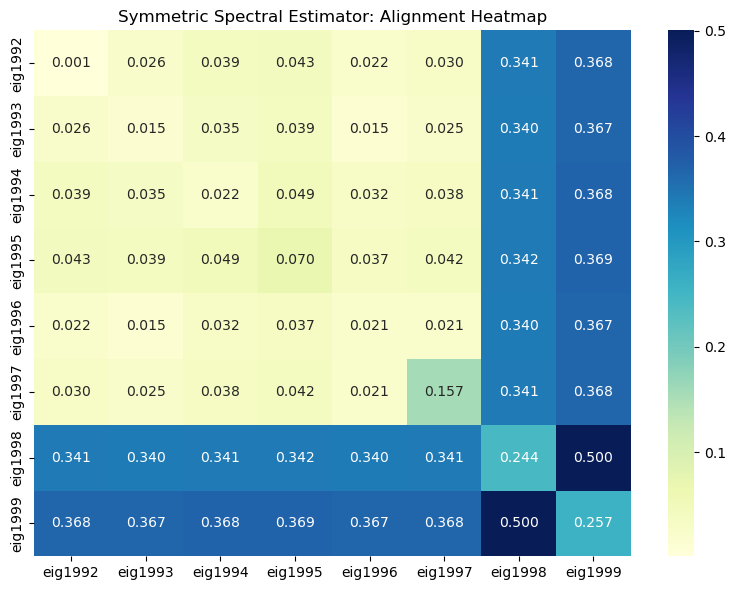


>>> [Heatmap Matrix for Symmetric Spectral Estimator]
         eig1992  eig1993  eig1994  eig1995  eig1996  eig1997  eig1998  \
eig1992    0.001    0.026    0.039    0.043    0.022    0.030    0.341   
eig1993    0.026    0.015    0.035    0.039    0.015    0.025    0.340   
eig1994    0.039    0.035    0.022    0.049    0.032    0.038    0.341   
eig1995    0.043    0.039    0.049    0.070    0.037    0.042    0.342   
eig1996    0.022    0.015    0.032    0.037    0.021    0.021    0.340   
eig1997    0.030    0.025    0.038    0.042    0.021    0.157    0.341   
eig1998    0.341    0.340    0.341    0.342    0.340    0.341    0.244   
eig1999    0.368    0.367    0.368    0.369    0.367    0.368    0.500   

         eig1999  
eig1992    0.368  
eig1993    0.367  
eig1994    0.368  
eig1995    0.369  
eig1996    0.367  
eig1997    0.368  
eig1998    0.500  
eig1999    0.257  


In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_alignment_heatmap(pair_df, title="Subspace Alignment Heatmap"):
    """
    输入 pair_df（包含特征值对的对齐得分），输出完整对称热力图。
    """
    # 提取所有特征组合得分
    labels = sorted(set([t.split('+')[0] for t in pair_df['Type']] + [t.split('+')[1] for t in pair_df['Type']]))
    heatmap_df = pd.DataFrame(np.nan, index=labels, columns=labels)

    # 填入组合对得分
    for _, row in pair_df.iterrows():
        eig_pair = row["Type"].split("+")
        score = row["Alignment Score"]
        heatmap_df.loc[eig_pair[0], eig_pair[1]] = score
        heatmap_df.loc[eig_pair[1], eig_pair[0]] = score  # 对称性填充

    # 自对齐填入 diagonal
    for idx in heatmap_df.index:
        heatmap_df.loc[idx, idx] = individual_df[individual_df["Type"] == idx]["Alignment Score"].values[0]

    # 绘图
    plt.figure(figsize=(8, 6))
    sns.heatmap(heatmap_df.astype(float), annot=True, fmt=".3f", cmap="YlGnBu", cbar=True)
    plt.title(title)
    plt.tight_layout()
    plt.show()

    return heatmap_df


heatmap_df = plot_alignment_heatmap(pair_df, title="Symmetric Spectral Estimator: Alignment Heatmap")
print("\n>>> [Heatmap Matrix for Symmetric Spectral Estimator]")
print(heatmap_df.round(3))


# 非对称

Using device: cpu
L shape: torch.Size([10000, 10000]), L device: cpu


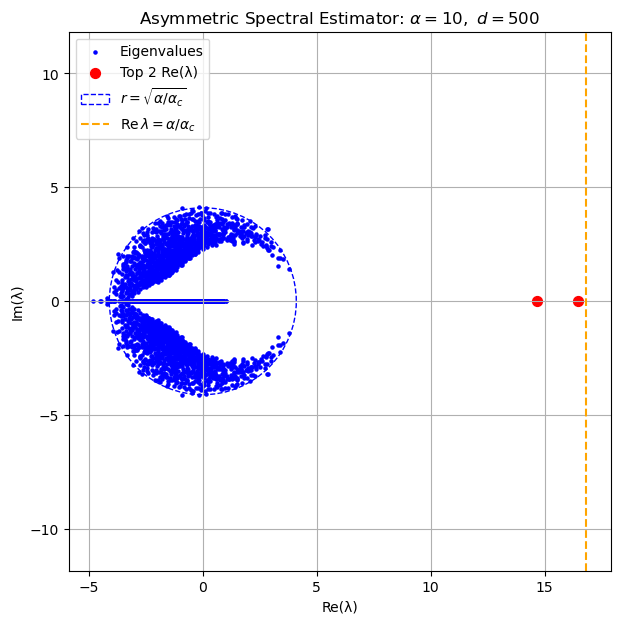

In [1]:
import os
import random
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import kv as besselk

# 固定随机种子（可复现性）
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(seed)

set_seed(42)

# 配置参数
n = 5000  # 样本数
p = 2      # 子空间维度
alpha = 10
alpha_c = 0.59375
d = int(n / alpha)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Step 1: 生成输入矩阵 X ∈ ℝ^{n × d}
X = torch.randn(n, d, device=device) / np.sqrt(d)

# Step 2: 构造信号子空间 W* 和观测 Z = X W*
W_star = torch.randn(d, p, device=device)
Z = X @ W_star
z1, z2 = Z[:, 0], Z[:, 1]
y = z1 * z2  # link function: y = z1 * z2

# Step 3: 计算预处理函数 G(y) ∈ ℝ^{n × p × p}
y_cpu = y.detach().cpu().numpy()
abs_y = np.abs(y_cpu)
K1 = besselk(1, abs_y)
K0 = besselk(0, abs_y)
lambda_y = abs_y * (K1 / K0) - 1
lambda_y[np.isnan(lambda_y)] = 0  # 数值稳定处理

# 构造 G(y): 每个样本一个 2x2 对称矩阵
G_y_np = np.zeros((n, p, p), dtype=np.float32)
G_y_np[:, 0, 0] = lambda_y
G_y_np[:, 1, 1] = lambda_y
G_y_np[:, 0, 1] = y_cpu
G_y_np[:, 1, 0] = y_cpu
G_y = torch.tensor(G_y_np, device=device)

# Step 4: 构造非对称谱矩阵 L ∈ ℝ^{np × np}
XXT = X @ X.T  # shape: (n, n)
XXT.fill_diagonal_(0.0)  # 去掉主对角线

# 构造谱矩阵 L 的 (iμ, jν) 元素
A = XXT[:, :, None, None]            # shape: (n, n, 1, 1)
G_broadcast = G_y[None, :, :, :]     # shape: (1, n, p, p)
L_blocks = A * G_broadcast           # shape: (n, n, p, p)
L = L_blocks.permute(0, 2, 1, 3).reshape(n * p, n * p)  # shape: (np, np)
print(f"L shape: {L.shape}, L device: {L.device}")

# Step 5: 计算特征值（在 GPU 上）并绘图
eigvals = torch.linalg.eigvals(L)
eigvals_np = eigvals.detach().cpu().numpy()
eigvals_real = eigvals_np.real

# 获取最大两个实部的特征值索引和特征值
top2_idx = np.argsort(eigvals_real)[-2:]
top2_vals = eigvals_np[top2_idx]

# 可视化谱图
plt.figure(figsize=(7, 7))
plt.scatter(eigvals_np.real, eigvals_np.imag, s=5, color='blue', label='Eigenvalues')
plt.scatter(top2_vals.real, top2_vals.imag, color='red', s=50, label='Top 2 Re(λ)')

# 理论谱圆半径和跳跃阈值
r = np.sqrt(alpha / alpha_c)
thresh = alpha / alpha_c

circle = plt.Circle((0, 0), r, color='blue', fill=False, linestyle='--',
                    label=rf'$r = \sqrt{{\alpha / \alpha_c}}$')
plt.gca().add_artist(circle)
plt.axvline(x=thresh, color='orange', linestyle='--',
            label=rf'$\mathrm{{Re}}\,\lambda = \alpha / \alpha_c$')

# 图形设置
plt.xlabel('Re(λ)')
plt.ylabel('Im(λ)')
plt.title(rf'Asymmetric Spectral Estimator: $\alpha = {alpha},\ d = {d}$')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()


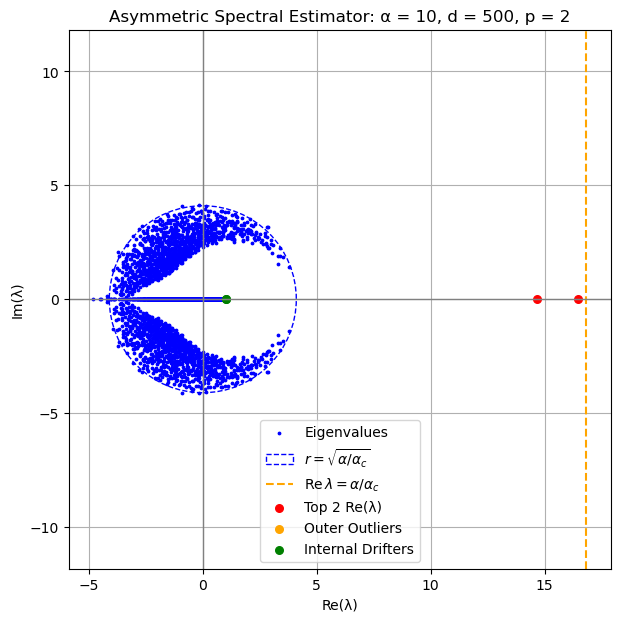


=== Alignment Score for Individual Eigenvalues ===
     Type                     λ  Alignment Score
0  Green1   1.035716+ 0.000000j         0.749039
1  Green2   1.002248+ 0.000000j         0.838734
2    Red1  16.468594+ 0.000000j         0.734306
3    Red2  14.676879+ 0.000000j         0.694126

=== Alignment Score for Pairs of Eigenvalues ===
            Pair                    λ1                    λ2  Alignment Score
3    Green2-Red1   1.002248+ 0.000000j  16.468594+ 0.000000j         0.838734
4    Green2-Red2   1.002248+ 0.000000j  14.676879+ 0.000000j         0.838734
0  Green1-Green2   1.035716+ 0.000000j   1.002248+ 0.000000j         0.749039
1    Green1-Red1   1.035716+ 0.000000j  16.468594+ 0.000000j         0.749039
2    Green1-Red2   1.035716+ 0.000000j  14.676879+ 0.000000j         0.749039
5      Red1-Red2  16.468594+ 0.000000j  14.676879+ 0.000000j         0.734306


/var/folders/kl/6hy0lk_14w14xqln8byr8l940000gn/T/ipykernel_24947/3798898805.py:207: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


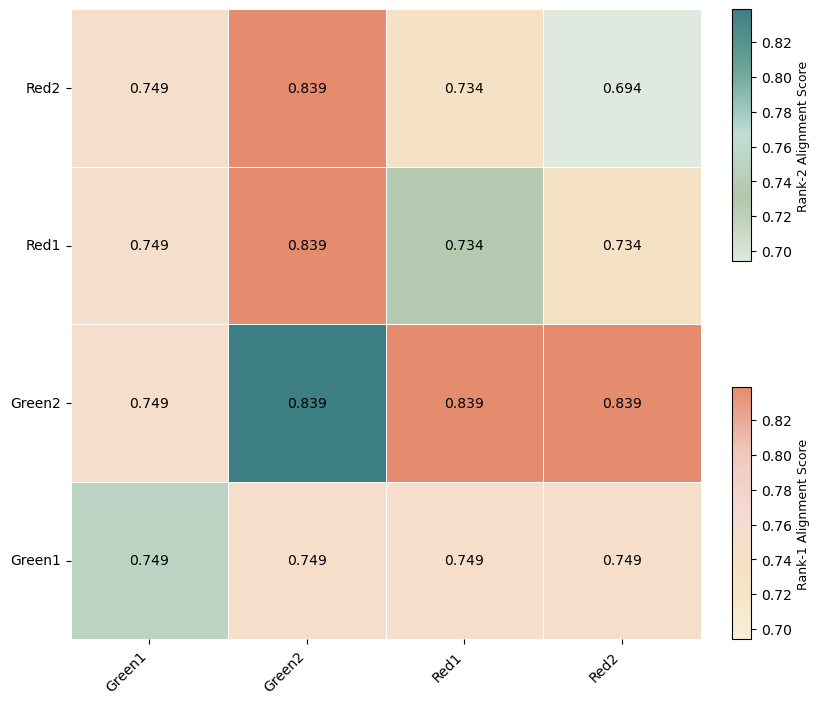

In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from numpy.linalg import norm
from scipy.linalg import qr
from itertools import combinations

# 计算判定边界
R = np.sqrt(alpha / alpha_c)        # 蓝色圆圈的半径
thresh_ext = alpha / alpha_c        # 橙色虚线的位置

# ========== 对齐度函数 ==========
def alignment_score(W_hat, W_star):
    Q1, _ = qr(W_hat, mode='economic')
    Q2, _ = qr(W_star, mode='economic')
    overlap = Q1.T @ Q2
    _, s, _ = np.linalg.svd(overlap)
    return np.mean(s)

# ========== 子空间提取（单个特征值） ==========
def extract_W_from_eigenvectors(eigvecs_np, eigval_target, X, W_star, p=2, label=""):
    idx = np.argmin(np.abs(eigvals_np - eigval_target))
    v_hat = eigvecs_np[:, idx]
    V = v_hat.reshape(-1, p)
    U = (X.cpu().numpy().T) @ V
    W_hat = U / np.linalg.norm(U, axis=0, keepdims=True)
    score = alignment_score(W_hat, W_star.cpu().numpy())
    return (label, eigval_target, score)

# ========== 子空间提取（特征值对组合） ==========
def extract_W_from_eigpair(eigvecs_np, eigvals_np, eigval_pair, X, W_star, p=2, label=""):
    idx1 = np.argmin(np.abs(eigvals_np - eigval_pair[0]))
    idx2 = np.argmin(np.abs(eigvals_np - eigval_pair[1]))
    v1 = eigvecs_np[:, idx1]
    v2 = eigvecs_np[:, idx2]
    V1 = v1.reshape(-1, p)
    V2 = v2.reshape(-1, p)
    V = np.hstack([V1, V2])
    U = X.cpu().numpy().T @ V
    W_hat = U[:, :p]
    W_hat = W_hat / norm(W_hat, axis=0, keepdims=True)
    score = alignment_score(W_hat, W_star.cpu().numpy())
    return (label, eigval_pair[0], eigval_pair[1], score)

# ========== 提取谱信息 ==========
eigvals, eigvecs = torch.linalg.eig(L)
eigvals_np = eigvals.cpu().numpy()
eigvecs_np = eigvecs.cpu().numpy()

# ========== 分类特征值（红橙绿） ==========


# ==== 基础变量 ====
R = np.sqrt(alpha / alpha_c)  # 半径阈值
eigvals_np = eigvals.cpu().numpy()
eigvals_real_only = [z for z in eigvals_np if np.isclose(z.imag, 0.0, atol=1e-6)]  # 只取实数谱点

# ==== 1. 红色点（Red）：半径外的前两个最大实部特征值 ====
outside_radius = [z for z in eigvals_real_only if abs(z) > R and z.real > 0]
red_vals = sorted(outside_radius, key=lambda z: z.real, reverse=True)[:2]

# ==== 2. 橙色点（Orange）：半径外、非红色的其他正实数特征值 ====
orange_vals = [z for z in outside_radius if z not in red_vals]

# ==== 3. 绿色点（Green）：半径内、落在实数轴上的前 n 个实部最大的特征值 ====
green_candidates = [z for z in eigvals_real_only if abs(z) <= R]
green_vals = sorted(green_candidates, key=lambda z: z.real, reverse=True)[:2]  # 可改为 [:n]





# ========== 正确编号（每组内实部大的是1） ==========
green_vals_sorted = sorted(green_vals, key=lambda z: z.real, reverse=True)
green_labels = [(f"Green{i+1}", z) for i, z in enumerate(green_vals_sorted)]

orange_vals_sorted = sorted(orange_vals, key=lambda z: z.real, reverse=True)
orange_labels = [(f"Orange{i+1}", z) for i, z in enumerate(orange_vals_sorted)]

red_vals_sorted = sorted(red_vals, key=lambda z: z.real, reverse=True)
red_labels = [(f"Red{i+1}", z) for i, z in enumerate(red_vals_sorted)]

# ========== 合并标签 ==========
all_labels = green_labels + orange_labels + red_labels
label_order = [label for label, _ in all_labels]  # Green1 Green2 Orange1 Orange2 Red1 Red2

# ========== 【一次性谱图绘制】 ==========
plt.figure(figsize=(7, 7))
plt.scatter(eigvals_np.real, eigvals_np.imag, color="blue", s=3, label="Eigenvalues")
circle = plt.Circle((0, 0), R, color="blue", linestyle="--", fill=False, label=r"$r = \sqrt{\alpha/\alpha_c}$")
plt.gca().add_artist(circle)
plt.axvline(thresh_ext, color="orange", linestyle="--", label=r"$\mathrm{Re}\,\lambda = \alpha/\alpha_c$")
plt.scatter([z.real for _, z in red_labels], [z.imag for _, z in red_labels], color="red", s=30, label="Top 2 Re(λ)")
plt.scatter([z.real for _, z in orange_labels], [z.imag for _, z in orange_labels], color="orange", s=30, label="Outer Outliers")
plt.scatter([z.real for _, z in green_labels], [z.imag for _, z in green_labels], color="green", s=30, label="Internal Drifters")
plt.axhline(0, color='gray', linewidth=1)
plt.axvline(0, color='gray', linewidth=1)
plt.xlabel("Re(λ)")
plt.ylabel("Im(λ)")
plt.title(f"Asymmetric Spectral Estimator: α = {alpha}, d = {d}, p = 2")
plt.legend()
plt.grid(True)
plt.axis("equal")
plt.show()

# ========== Code 1：单点对齐得分 ==========
results_single = []
for label, z in all_labels:
    results_single.append(extract_W_from_eigenvectors(eigvecs_np, z, X, W_star, p=2, label=label))
df_single = pd.DataFrame(results_single, columns=["Type", "λ", "Alignment Score"])
print("\n=== Alignment Score for Individual Eigenvalues ===")
print(df_single)

# ========== Code 2：两两组合对齐得分 ==========
results_pair = []
for (label1, z1), (label2, z2) in combinations(all_labels, 2):
    pair_label = f"{label1}-{label2}"
    results_pair.append(extract_W_from_eigpair(eigvecs_np, eigvals_np, (z1, z2), X, W_star, p=2, label=pair_label))
df_pair = pd.DataFrame(results_pair, columns=["Pair", "λ1", "λ2", "Alignment Score"])
print("\n=== Alignment Score for Pairs of Eigenvalues ===")
print(df_pair.sort_values(by="Alignment Score", ascending=False))

# ========== Code 3：热力图绘制 ==========


# ========== 创建热力图数据 ==========
# 初始化 DataFrame
heatmap_df = pd.DataFrame(np.nan, index=label_order, columns=label_order)

# 填入单点（对角线）得分
for _, row in df_single.iterrows():
    label = row["Type"]
    score = row["Alignment Score"]
    heatmap_df.loc[label, label] = score

# 填入两两组合（非对角线）得分
for _, row in df_pair.iterrows():
    label1, label2 = row["Pair"].split("-")
    score = row["Alignment Score"]
    heatmap_df.loc[label1, label2] = score
    heatmap_df.loc[label2, label1] = score  # 对称填充

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes



# 颜色列表
diag_colors = ["#FAEED9", "#F5E3C2", "#F5DBD4", "#F0C7BC", "#E58B6E"]
offdiag_colors = ["#DFE9DF", "#B2C6AB", "#C2DED7", "#6DA798", "#3E7F84"]
diag_cmap = LinearSegmentedColormap.from_list("diag_cmap", diag_colors)
offdiag_cmap = LinearSegmentedColormap.from_list("offdiag_cmap", offdiag_colors)



# 创建 mask
mask_diag = pd.DataFrame(True, index=label_order, columns=label_order)
np.fill_diagonal(mask_diag.values, False)
mask_offdiag = ~mask_diag

# 值范围
vmin = np.nanmin(heatmap_df.values)
vmax = np.nanmax(heatmap_df.values)

# 创建图形
fig, ax = plt.subplots(figsize=(8, 7))

# plot1: off-diagonal（Rank-2）
sns.heatmap(heatmap_df, mask=mask_diag, cmap=offdiag_cmap, vmin=vmin, vmax=vmax,
            square=True, linewidths=0.5, cbar=False, ax=ax)

# 添加紧凑 colorbar
cbar_ax1 = inset_axes(ax, width="3%", height="40%", loc='upper right', bbox_to_anchor=(0.08, 0, 1, 1), bbox_transform=ax.transAxes, borderpad=0)
sm1 = plt.cm.ScalarMappable(cmap=offdiag_cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar1 = fig.colorbar(sm1, cax=cbar_ax1)
cbar1.set_label("Rank-2 Alignment Score", fontsize=9)

# plot2: diagonal（Rank-1）
sns.heatmap(heatmap_df, mask=mask_offdiag, cmap=diag_cmap, vmin=vmin, vmax=vmax,
            square=True, linewidths=0.5, cbar=False, ax=ax)

# 添加第二个 colorbar
cbar_ax2 = inset_axes(ax, width="3%", height="40%", loc='lower right', bbox_to_anchor=(0.08, 0, 1, 1), bbox_transform=ax.transAxes, borderpad=0)
sm2 = plt.cm.ScalarMappable(cmap=diag_cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar2 = fig.colorbar(sm2, cax=cbar_ax2)
cbar2.set_label("Rank-1 Alignment Score", fontsize=9)

# 注释数值
for i in range(len(label_order)):
    for j in range(len(label_order)):
        val = heatmap_df.iloc[i, j]
        if not np.isnan(val):
            ax.text(j + 0.5, i + 0.5, f"{val:.3f}", ha='center', va='center', fontsize=10)

# 美化

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.invert_yaxis()

plt.tight_layout()
plt.subplots_adjust(left=0.05, right=0.90, top=0.95, bottom=0.05)

plt.show()



In [7]:
print(results_single)

[('Green1', (1.0357158+0j), 0.749039), ('Green2', (1.0022476+0j), 0.8387339), ('Red1', (16.468594+0j), 0.73430634), ('Red2', (14.676879+0j), 0.69412565)]


In [9]:
print(results_pair )

[('Green1-Green2', (1.0357158+0j), (1.0022476+0j), 0.749039), ('Green1-Red1', (1.0357158+0j), (16.468594+0j), 0.749039), ('Green1-Red2', (1.0357158+0j), (14.676879+0j), 0.749039), ('Green2-Red1', (1.0022476+0j), (16.468594+0j), 0.8387339), ('Green2-Red2', (1.0022476+0j), (14.676879+0j), 0.8387339), ('Red1-Red2', (16.468594+0j), (14.676879+0j), 0.73430634)]


In [5]:
import numpy as np
import pandas as pd
from scipy.linalg import qr
from numpy.linalg import norm

def alignment_score(W_hat, W_star):
    Q1, _ = qr(W_hat, mode='economic')
    Q2, _ = qr(W_star, mode='economic')
    overlap = Q1.T @ Q2
    _, s, _ = np.linalg.svd(overlap)
    return np.mean(s)

def map_multiple_eigvecs_to_2d(eigvecs_np, eigvals_np, selected_eigvals, X, W_star, eigval_to_label, p=2):
    """
    映射多个非对称谱估计器的特征向量到 2d 空间，计算每个单点的对齐度，并附带标签显示。

    参数:
        eigvecs_np: ndarray, shape (n*p, n*p) — 所有特征向量矩阵
        eigvals_np: ndarray, shape (n*p,) — 所有特征值列表
        selected_eigvals: list — 需要计算的特征值
        X: ndarray, shape (n, d) — 原始输入样本矩阵
        W_star: ndarray, shape (d, p) — 真实信号子空间矩阵
        eigval_to_label: dict — 特征值到标签的映射字典（如 "Red1", "Green2"）
        p: int — 信号子空间维度，默认2

    返回:
        pd.DataFrame — 包含标签、索引、对齐分数的结果表
    """
    n, d = X.shape
    results = []

    # 真实信号子空间映射成 (2d, p) 形状，方便对齐
    W_star_2d = np.vstack([W_star[:, i].reshape(-1,1) for i in range(p)])

    for val in selected_eigvals:
        idx = np.argmin(np.abs(eigvals_np - val))
        v = eigvecs_np[:, idx]  # shape (n*p,)
        V = v.reshape(n, p)      # reshape为 (n, p)

        if p == 1:
            mapped_vec = X.T @ V[:, 0]         # (d,)
            mapped_vec = mapped_vec.reshape(d, 1)
        elif p == 2:
            v0 = X.T @ V[:, 0]                 # (d,)
            v1 = X.T @ V[:, 1]                 # (d,)
            mapped_vec = np.vstack([v0.reshape(-1,1), v1.reshape(-1,1)])  # (2d, 1)
        else:
            raise NotImplementedError("目前只支持 p=1 或 p=2")

        eps = 1e-12
        mapped_vec /= (norm(mapped_vec, axis=0, keepdims=True) + eps)

        score = alignment_score(mapped_vec, W_star_2d)
        label = eigval_to_label.get(val, f"Unknown_{val}")
        results.append({"Eigenvalue": label, "Index": idx, "Alignment Score": score})

    return pd.DataFrame(results)


# ====== 示例调用 ======

# 假设你已经有这些变量
# eigvals_np, eigvecs_np, red_labels, orange_labels, green_labels, X, W_star

eigval_to_label = {val: label for label, val in red_labels + orange_labels + green_labels}
selected_eigvals = [val for _, val in red_labels + orange_labels + green_labels]

df_scores = map_multiple_eigvecs_to_2d(
    eigvecs_np,
    eigvals_np,
    selected_eigvals,
    X.cpu().numpy(),
    W_star.cpu().numpy(),
    eigval_to_label,
    p=2
)

print(df_scores)


  Eigenvalue  Index  Alignment Score
0       Red1      0         0.546872
1       Red2      1         0.538104
2     Green1   3093         0.622606
3     Green2   3094         0.624811


#### 注意！！在两个点进行组合映射到过程中，是先组合再映射到2d维。避免了在一个点中出现的可能存在消弱，映射本质上是一个核空间向原始特征空间的投影，难免带来信息损失和误差。

In [13]:
import numpy as np
from scipy.linalg import qr
from numpy.linalg import norm
import pandas as pd

def joint_map_and_align(eigvecs_np, eigvals_np, pairs, X, W_star, p=2):
    """
    对每对特征值组合的特征向量进行联合映射并计算对齐分数。

    参数:
        eigvecs_np: ndarray, shape (np, np) 所有特征向量
        eigvals_np: ndarray, shape (np,) 所有特征值
        pairs: list of tuples, [(label1, eigval1, label2, eigval2), ...]
        X: ndarray, (n, d) 输入样本矩阵
        W_star: ndarray, (d, p) 真实信号子空间
        p: int, 子空间维度，默认2

    返回:
        pd.DataFrame，包含每对组合的对齐分数
    """

    n, d = X.shape
    results = []

    # 真实信号子空间映射到 2d 维（拼接p列）
    W_star_2d = np.vstack([W_star[:, i].reshape(-1, 1) for i in range(p)])  # (2d, p)

    for (label1, val1, label2, val2) in pairs:
        # 找特征向量索引
        idx1 = np.argmin(np.abs(eigvals_np - val1))
        idx2 = np.argmin(np.abs(eigvals_np - val2))

        # 取对应特征向量
        v1 = eigvecs_np[:, idx1]
        v2 = eigvecs_np[:, idx2]

        # reshape 成 (n, p)
        V1 = v1.reshape(n, p)
        V2 = v2.reshape(n, p)

        # 组合成 (n, p, 2)
        V_combined = np.stack([V1, V2], axis=2)  # shape (n, p, 2)

        # 投影回原空间，分别投影每个 p 维向量，拼接
        mapped_columns = []
        for pi in range(p):
            # X.T @ V_combined[:, pi, :] => (d, 2)
            mapped_columns.append(X.T @ V_combined[:, pi, :])  
        W_hat = np.vstack(mapped_columns)  # (2d, 2)

        # 归一化每列
        W_hat /= (norm(W_hat, axis=0, keepdims=True) + 1e-12)

        # QR + SVD 计算子空间对齐度
        Q1, _ = qr(W_hat, mode='economic')
        Q2, _ = qr(W_star_2d, mode='economic')
        overlap = Q1.T @ Q2
        _, s, _ = np.linalg.svd(overlap)
        score = np.mean(s)

        results.append({
            "Pair": f"{label1}-{label2}",
            "Eigenvalue1": val1,
            "Eigenvalue2": val2,
            "Alignment Score": score
        })

    return pd.DataFrame(results)

# ====== 生成两两组合 pairs ======

# 假设你有以下变量（格式示例）：
# red_labels = [('Red1', 9.3182), ('Red2', 8.4258)]
# orange_labels = [('Orange1', 3.6645)]
# green_labels = [('Green1', 2.3144), ('Green2', 1.0173)]

# 生成所有两两组合（含跨类别组合）
import itertools

all_labels = red_labels + orange_labels + green_labels

pairs = []
for (label1, val1), (label2, val2) in itertools.combinations(all_labels, 2):
    pairs.append((label1, val1, label2, val2))

# ====== 调用函数 ======
df_pairs_scores = joint_map_and_align(eigvecs_np, eigvals_np, pairs, 
                                     X.cpu().numpy(), W_star.cpu().numpy(), p=2)

# 按对齐分数排序，查看效果最好组合
df_pairs_scores = df_pairs_scores.sort_values(by="Alignment Score", ascending=False).reset_index(drop=True)
print(df_pairs_scores)


            Pair           Eigenvalue1           Eigenvalue2  Alignment Score
0  Green1-Green2   1.035716+ 0.000000j   1.002248+ 0.000000j         0.882069
1    Red1-Green1  16.468594+ 0.000000j   1.035716+ 0.000000j         0.828681
2    Red2-Green2  14.676879+ 0.000000j   1.002248+ 0.000000j         0.824593
3      Red1-Red2  16.468594+ 0.000000j  14.676879+ 0.000000j         0.767218
4    Red2-Green1  14.676879+ 0.000000j   1.035716+ 0.000000j         0.638960
5    Red1-Green2  16.468594+ 0.000000j   1.002248+ 0.000000j         0.637878
